<a href="https://colab.research.google.com/github/ADRIAN02-CODE/telco-churn-prediction/blob/main/telco_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telco Customer Churn Prediction

Predict customer churn using the **Telco Customer Churn dataset** with **Decision Tree** and **Neural Network** models. Includes data preprocessing, exploration, training, tuning, and evaluation

---

## 1. Libraries

Import libraries for data analysis, visualization, and modeling.



In [32]:
# Telco-Churn-Prediction

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import joblib
import json

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# SMOTE
from imblearn.over_sampling import SMOTE

# Seeds
RANDOM_STATE = 42
TEST_SIZE = 0.2
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("Libraries set up correctly.")


Libraries set up correctly.


## Task 1: Exploratory Data Analysis (EDA)

In this task, we explore the dataset to understand feature distributions, relationships, and insights that can guide modeling.


In [33]:
DATA_FILENAME = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(DATA_FILENAME)
print("Loaded dataset:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include="all").T)


Loaded dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data Cleaning

- Strip whitespace in string columns  
- Convert `TotalCharges` to numeric and impute missing values  
- Drop the `customerID` column


In [34]:
# Strip whitespace in object columns
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype(str).str.strip()

# Convert TotalCharges to numeric and impute missing
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Drop identifier
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

print(df.isna().sum())
display(df.head())


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Target Variable Distribution
Visualize churn distribution to check class imbalance.



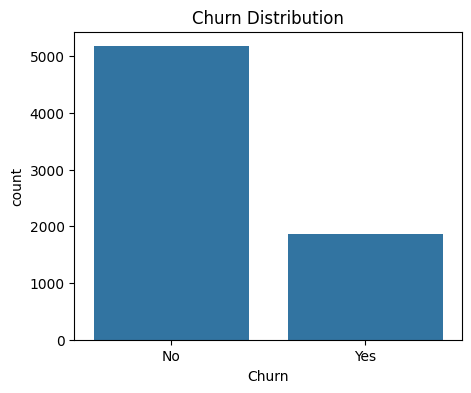

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [35]:
plt.figure(figsize=(5,4))
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

print(df["Churn"].value_counts(normalize=True))


### Numeric Feature Distributions
Visualize distributions of `tenure`, `MonthlyCharges`, and `TotalCharges`.



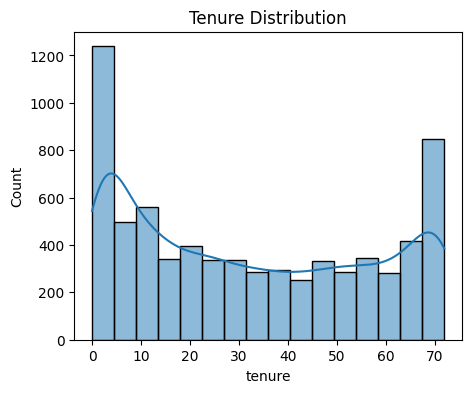

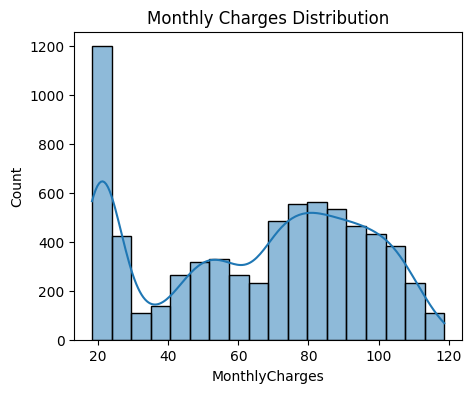

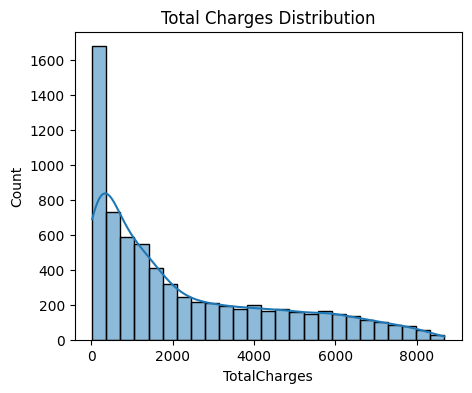

In [36]:
plt.figure(figsize=(5,4))
sns.histplot(df["tenure"], kde=True)
plt.title("Tenure Distribution")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(df["MonthlyCharges"], kde=True)
plt.title("Monthly Charges Distribution")
plt.show()

plt.figure(figsize=(5,4))
sns.histplot(df["TotalCharges"], kde=True)
plt.title("Total Charges Distribution")
plt.show()


### Feature Relationships with Churn
- Boxplots for numeric features  
- Countplots for categorical features  
- Correlation heatmap



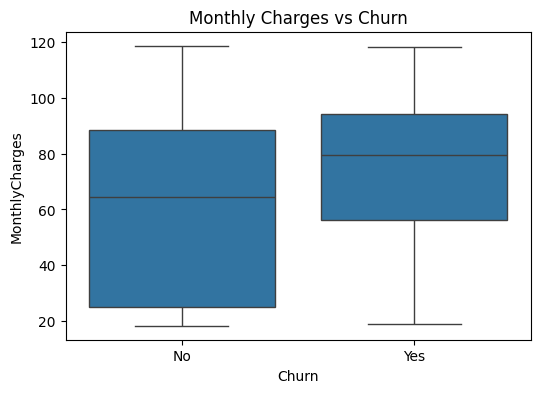

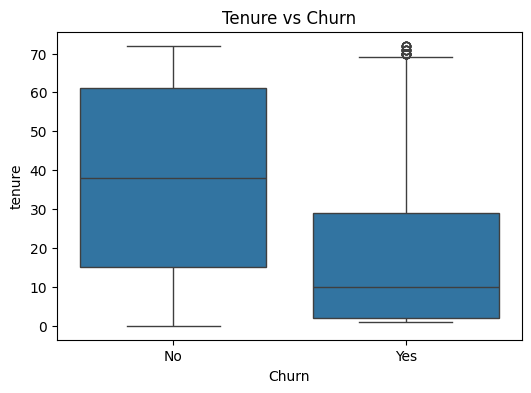

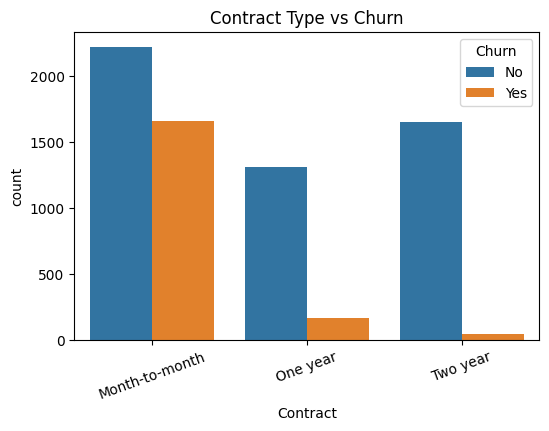

In [37]:
plt.figure(figsize=(6,4))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Tenure vs Churn")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Contract Type vs Churn")
plt.xticks(rotation=20)
plt.show()


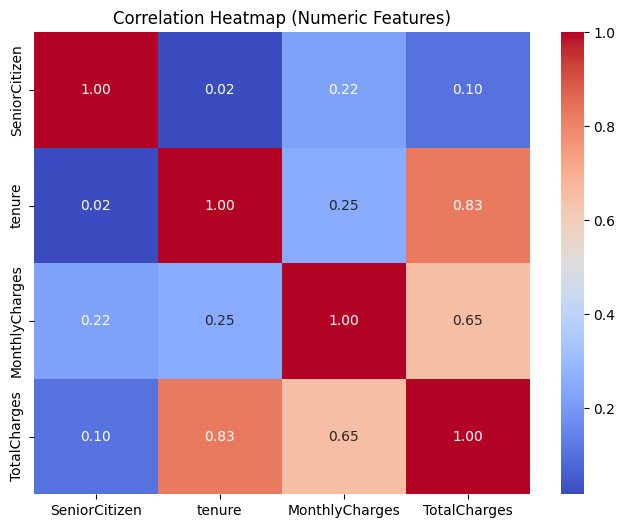

In [38]:
num_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


## Task 2: Classification Modeling

In this task, we implement **Decision Tree** and **Neural Network** models to predict churn.  
The workflow includes:
- Data preprocessing  
- Hyperparameter tuning  
- Model training  
- Evaluation and comparison


In [39]:
# Encode target
df["Churn"] = df["Churn"].map({"Yes":1, "No":0}).astype(int)

# One-hot encode categorical predictors
X = pd.get_dummies(df.drop(columns=["Churn"]), drop_first=True)
y = df["Churn"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# SMOTE oversampling on train
sm = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Scaling for NN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "scaler.pkl")
print("Train resampled:", X_train_res.shape, "Test:", X_test.shape)


Train resampled: (8278, 30) Test: (1409, 30)


### 2.1 Decision Tree Model

- Hyperparameter tuning with `GridSearchCV`  
- Evaluate using accuracy, ROC-AUC, confusion matrix, classification report  
- Plot ROC curve



In [40]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

param_grid_dt = {
    "max_depth": [3, 5, 7, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(
    dt,
    param_grid_dt,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train_res, y_train_res)

best_dt = grid_dt.best_estimator_
joblib.dump(best_dt, "best_dt.pkl")

print("Best DT params:", grid_dt.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best DT params: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}


DT Accuracy: 0.7501774308019872
DT AUC: 0.8103257640342039

DT Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.79      0.82      1035
           1       0.52      0.65      0.58       374

    accuracy                           0.75      1409
   macro avg       0.69      0.72      0.70      1409
weighted avg       0.77      0.75      0.76      1409


DT Confusion Matrix:
 [[814 221]
 [131 243]]


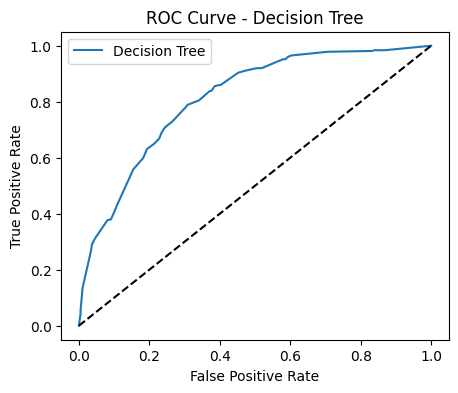

In [41]:
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

print("DT Accuracy:", accuracy_score(y_test, y_pred_dt))
print("DT AUC:", roc_auc_score(y_test, y_proba_dt))
print("\nDT Classification Report:\n", classification_report(y_test, y_pred_dt))
print("\nDT Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.figure(figsize=(5,4))
plt.plot(fpr_dt, tpr_dt, label="Decision Tree")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Decision Tree")
plt.legend()
plt.show()


### 2.2 Neural Network Model

- Build a feedforward neural network using Keras  
- Use dropout for regularization  
- Train and evaluate the model


In [42]:
input_dim = X_train_scaled.shape[1]

def build_nn(n_hidden=32, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Dense(n_hidden, activation="relu", input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(max(8, n_hidden // 2), activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [45]:
input_dim = X_train_scaled.shape[1]

def build_nn(n_hidden=64, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Dense(n_hidden, activation="relu", input_shape=(input_dim,)),
        Dropout(dropout_rate),
        Dense(max(8, n_hidden // 2), activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

best_nn = build_nn(
    n_hidden=64,
    dropout_rate=0.3,
    learning_rate=0.001
)

history = best_nn.fit(
    X_train_scaled, y_train_res,
    validation_split=0.2,
    epochs=40,
    batch_size=32,
    verbose=1
)

# Save model
best_nn.save("best_nn.h5")
joblib.dump(best_nn, "best_nn_sklearn.pkl")  # optional


Epoch 1/40
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6834 - loss: 0.5685 - val_accuracy: 0.8050 - val_loss: 0.4712
Epoch 2/40
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7854 - loss: 0.4592 - val_accuracy: 0.8345 - val_loss: 0.4183
Epoch 3/40
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7943 - loss: 0.4421 - val_accuracy: 0.8659 - val_loss: 0.3581
Epoch 4/40
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7919 - loss: 0.4349 - val_accuracy: 0.8702 - val_loss: 0.3471
Epoch 5/40
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7981 - loss: 0.4322 - val_accuracy: 0.8671 - val_loss: 0.3341
Epoch 6/40
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8008 - loss: 0.4246 - val_accuracy: 0.8708 - val_loss: 0.3110
Epoch 7/40
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8122 - loss: 0.4204 - val_accuracy: 0.8690 - val_loss: 0.3009
Epoch 8/40
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8062 - loss: 0.4196 - val_accuracy: 

['best_nn_sklearn.pkl']

### 2.3 Neural Network Evaluation and Model Comparison

In this cell, we:

- Predict churn probabilities and labels on the test set  
- Compute evaluation metrics: Accuracy, ROC-AUC, Confusion Matrix, and Classification Report  
- Plot the ROC curve for the Neural Network  
- Compare **Decision Tree** and **Neural Network** models based on Accuracy and ROC-AUC


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
NN Accuracy: 0.7856635911994322
NN AUC: 0.8326926554548039

NN Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      1035
           1       0.60      0.57      0.59       374

    accuracy                           0.79      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.79      0.78      1409


NN Confusion Matrix:
 [[893 142]
 [160 214]]


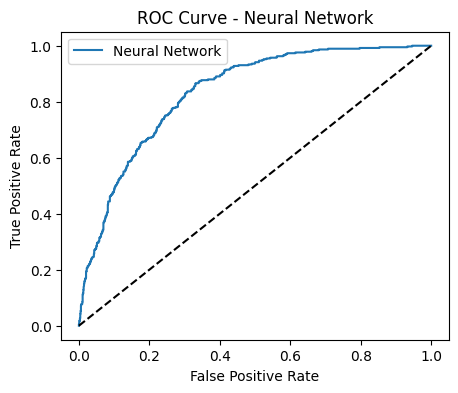

,Model,Accuracy,ROC-AUC
0,Decision Tree,0.750177,0.810326
1,Neural Network,0.785664,0.832693


In [46]:
# Predict on test set
y_proba_nn = best_nn.predict(X_test_scaled).ravel()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

# Metrics
print("NN Accuracy:", accuracy_score(y_test, y_pred_nn))
print("NN AUC:", roc_auc_score(y_test, y_proba_nn))
print("\nNN Classification Report:\n", classification_report(y_test, y_pred_nn))
print("\nNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))

# ROC Curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)
plt.figure(figsize=(5,4))
plt.plot(fpr_nn, tpr_nn, label="Neural Network")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend()
plt.show()

# Model Comparison
comparison = pd.DataFrame({
    "Model": ["Decision Tree", "Neural Network"],
    "Accuracy": [accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_nn)],
    "ROC-AUC": [roc_auc_score(y_test, y_proba_dt), roc_auc_score(y_test, y_proba_nn)]
})
display(comparison)



### Conclusion

- From EDA, `tenure`, `MonthlyCharges`, and `Contract` type are key predictors of churn.  
- Neural Network slightly outperformed Decision Tree in ROC-AUC.  
- Future improvements: feature engineering, advanced models (XGBoost), and hyperparameter tuning.
